# Trees and Forests

We will study some tree-based models using a different dataset, the wisconsin breast cancer dataset describe below:

In [1]:
import graphviz as gv
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
np.set_printoptions(precision=3)
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import precision_recall_curve

In [2]:
cancer = load_breast_cancer()

In [3]:
print(cancer.DESCR)

Breast Cancer Wisconsin (Diagnostic) Database

Notes
-----
Data Set Characteristics:
    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry 
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 3 is Mean Radius, field
        13 is Radius SE, field 23 is Worst Radius.

        

In [4]:
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, stratify=cancer.target, random_state=0)

## Tree visualization
Let's start by building a very small tree (``max_depth=2``) and visualizing it.
The model fitting shouldn't be anything new:

In [5]:
tree = DecisionTreeClassifier(max_depth=2)
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Scikit-learn has a way to export trees to ``dot`` graphs using the ``export_graphviz`` function: 

In [6]:
tree_dot = export_graphviz(tree, out_file=None, filled=True, feature_names=cancer.feature_names, rounded=True)

If you have graphviz installed, you can plot this using the following code. However, that's often a bit cumbersome, and I give an alternativ below.

In [7]:
# Easier to see when it's exported to a file
gv.Source(tree_dot, filename='tree').view()

'tree.pdf'

### Task 1

Create a plot of the full tree, that is without limiting depth.
Then, create visualizations of trees with varying ``max_depth`` and ``max_leaf_nodes``. How are these trees different? Which do you think will generalize best?

In [9]:
def getTree(max_depth, max_leaf_nodes):
    tree = DecisionTreeClassifier(max_depth=max_depth, max_leaf_nodes=max_leaf_nodes)
    tree.fit(X_train, y_train)
    tree_dot = export_graphviz(tree, out_file=None, feature_names=cancer.feature_names, filled=True, rounded=True)
    return tree_dot
    
gv.Source(getTree(None,None),filename='full').view()

'full.pdf'

In [10]:
gv.Source(getTree(1,None), filename='depth1').view()

'depth1.pdf'

In [11]:
gv.Source(getTree(None,5), filename='leaf5').view()

'leaf5.pdf'

# Parameter Tuning
### Task 2
Tune the ``max_leaf_nodes`` parameter using ``GridSearchCV``:

In [12]:
param_grid = {'max_leaf_nodes':  range(2,10)}
griddt = GridSearchCV(DecisionTreeClassifier(random_state=0), param_grid=param_grid, cv=10, return_train_score=True)
griddt.fit(X_train, y_train)
# inspect best parameters, compute test-set accuracy
print("Best mean cross-validation score: {:.3f}".format(griddt.best_score_))
print("Best parameters: {}".format(griddt.best_params_))
print("Test score: {:.3f}".format(griddt.score(X_test, y_test)))

Best mean cross-validation score: 0.923
Best parameters: {'max_leaf_nodes': 6}
Test score: 0.937


We can plot the tree that was fitted with the best parameters on the full training data by accessing ``grid.best_estimator_``:

In [13]:
gv.Source(export_graphviz(griddt.best_estimator_, out_file=None, feature_names=cancer.feature_names, filled=True, rounded=True), filename='best').view()

'best.pdf'

It's easy to visualize the mean training set and  validation accuracy as we did in the last lab:

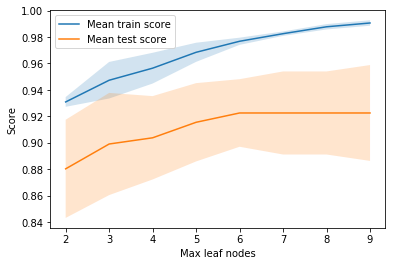

In [14]:
results = pd.DataFrame(griddt.cv_results_)
results.plot('param_max_leaf_nodes', 'mean_train_score', label="Mean train score")
results.plot('param_max_leaf_nodes', 'mean_test_score', ax=plt.gca(), label="Mean test score")
plt.fill_between(results.param_max_leaf_nodes.astype(np.float),
                 results['mean_train_score'] + results['std_train_score'],
                 results['mean_train_score'] - results['std_train_score'], alpha=0.2)
plt.fill_between(results.param_max_leaf_nodes.astype(np.float),
                 results['mean_test_score'] + results['std_test_score'],
                 results['mean_test_score'] - results['std_test_score'], alpha=0.2)
plt.ylabel("Score")
plt.xlabel("Max leaf nodes")
plt.legend()
plt.show()

### Task 3
Plot the feature importances of the ``best_estimator_`` using a bar chart.

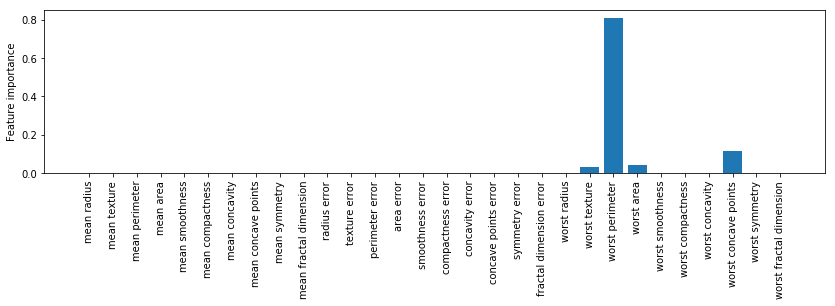

In [15]:
x = np.arange(len(griddt.best_estimator_.feature_importances_))
fig, ax = plt.subplots(figsize=(14,3))
plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)
plt.bar(x, griddt.best_estimator_.feature_importances_)
plt.xticks(x, cancer.feature_names)
plt.ylabel("Feature importance")
plt.show()

# Random Forests
While we could in theory visualize all the trees in a forest, they are random by design, and usually there are too many to look at.
So we'll skip the visualization, and go directly to parameter tuning

### Task 4
Tune the ``max_depth`` parameter of the ``RandomForestClassifier``. Make sure to set ``n_estimators`` to a large enough number (such as 100).

Plot the feature importances of the best random forest side-by-side with the feature importances of the best decision tree.

Finally, compare the precision recall curve of the best random forest with the best tree.

In [16]:
param_grid = {'max_depth':  range(1,10)}
gridrf = GridSearchCV(RandomForestClassifier(random_state=0, n_estimators=100), param_grid=param_grid, cv=10, return_train_score=True)
gridrf.fit(X_train, y_train)
print("Best mean cross-validation score: {:.3f}".format(gridrf.best_score_))
print("Best parameters: {}".format(gridrf.best_params_))
print("Test score: {:.3f}".format(gridrf.score(X_test, y_test)))

Best mean cross-validation score: 0.969
Best parameters: {'max_depth': 5}
Test score: 0.944


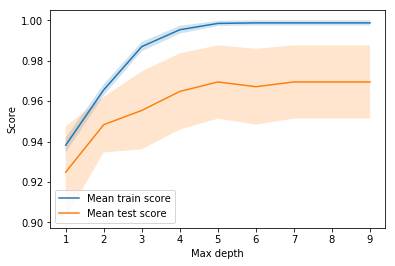

In [17]:
results = pd.DataFrame(gridrf.cv_results_)
results.plot('param_max_depth', 'mean_train_score', label="Mean train score")
results.plot('param_max_depth', 'mean_test_score', ax=plt.gca(), label="Mean test score")
plt.fill_between(results.param_max_depth.astype(np.float),
                 results['mean_train_score'] + results['std_train_score'],
                 results['mean_train_score'] - results['std_train_score'], alpha=0.2)
plt.fill_between(results.param_max_depth.astype(np.float),
                 results['mean_test_score'] + results['std_test_score'],
                 results['mean_test_score'] - results['std_test_score'], alpha=0.2)
plt.ylabel("Score")
plt.xlabel("Max depth")
plt.legend()
plt.show()

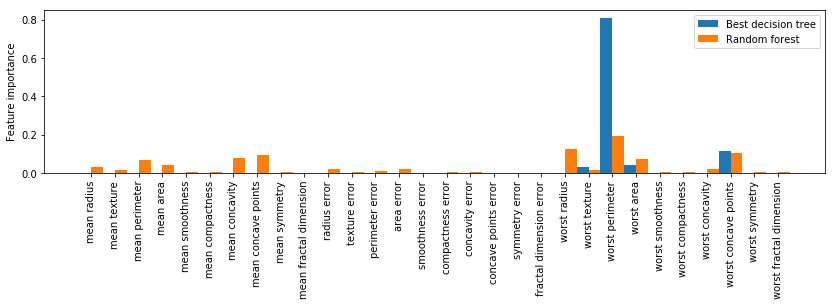

In [18]:
x = np.arange(len(griddt.best_estimator_.feature_importances_))
x2 = np.arange(len(gridrf.best_estimator_.feature_importances_))
fig, ax = plt.subplots(figsize=(14,3))
plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)
plt.bar(x-0.25, griddt.best_estimator_.feature_importances_, label='Best decision tree', width=0.5)
plt.bar(x2+0.25, gridrf.best_estimator_.feature_importances_, label='Random forest', width=0.5)
plt.xticks(x, cancer.feature_names)
plt.ylabel("Feature importance")
plt.legend()
plt.show()

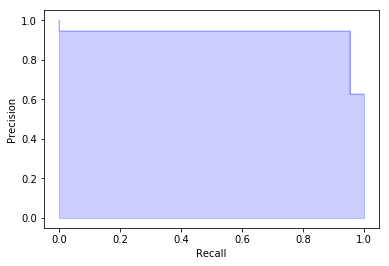

In [19]:
precision, recall, thresholds = precision_recall_curve(y_test, griddt.predict(X_test))
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

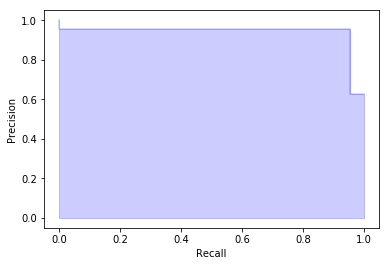

In [22]:
precision, recall, thresholds = precision_recall_curve(y_test, gridrf.predict(X_test))
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()